In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_49.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_67_1.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_90.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_77.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_20_1.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_66.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_54.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_106_1.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_42.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_81.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_72.wav
/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_107.wav
/kaggle/input/shl-in

In [2]:
# Load training CSV
train_df = pd.read_csv('/kaggle/input/shl-intern-hiring-assessment-2025/dataset/csvs/train.csv')
train_df.head()


,filename,label
0,audio_173,3.0
1,audio_138,3.0
2,audio_127,2.0
3,audio_95,2.0
4,audio_73,3.5


In [3]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409 entries, 0 to 408
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  409 non-null    object 
 1   label     409 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.5+ KB


In [4]:
# Count audio files
audio_dir = '/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/train'
print("Total audio files:", len(os.listdir(audio_dir)))


Total audio files: 409


**🧠 Transcribing Audio with Whisper**

To begin the grammar scoring task, I needed to convert the audio files into text so I could analyze the grammar. For this, I used OpenAI's Whisper model, which is great for automatic speech recognition. I chose the "tiny" version to keep things lightweight and fast enough for batch processing.

I loaded the training audio file names from the CSV and then transcribed them in four batches to avoid memory issues. Each audio file was passed through the Whisper model, and the resulting transcript was added to the dataset. This step gave me the raw text needed for further linguistic feature extraction.

In [6]:
!pip install -q git+https://github.com/openai/whisper.git
!pip install -q language-tool-python

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 7.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.

In [7]:
import whisper
import language_tool_python
import pandas as pd
import numpy as np
import os
import librosa
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [9]:
# Load full training data
train_df = pd.read_csv('/kaggle/input/shl-intern-hiring-assessment-2025/dataset/csvs/train.csv')
audio_dir = '/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/train'

# Load Whisper model
import whisper
model = whisper.load_model("tiny")

# Transcription function
def transcribe_audio(filename):
    
    path = os.path.join(audio_dir, f"{filename}.wav")
    try:
        result = model.transcribe(path)
        return result['text']
    except Exception as e:
        print(f"Error transcribing {filename}: {e}")
        return ""

# Batch 1: index 0–99
batch1 = train_df.iloc[0:100].copy()
batch1['transcript'] = batch1['filename'].apply(transcribe_audio)

# Batch 2: index 100–199
batch2 = train_df.iloc[100:200].copy()
batch2['transcript'] = batch2['filename'].apply(transcribe_audio)

# Batch 3: index 200–299
batch3 = train_df.iloc[200:300].copy()
batch3['transcript'] = batch3['filename'].apply(transcribe_audio)

# Batch 4: index 300–408
batch4 = train_df.iloc[300:].copy()
batch4['transcript'] = batch4['filename'].apply(transcribe_audio)


100%|██████████████████████████████████████| 72.1M/72.1M [00:00<00:00, 133MiB/s]
/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  

In [10]:
# Combine all batches
full_df = pd.concat([batch1, batch2, batch3, batch4], ignore_index=True)

# Save to working directory
full_df.to_csv('/kaggle/working/train_transcripts_full.csv', index=False)

# Preview
full_df[['filename', 'label', 'transcript']].head()


,filename,label,transcript
0,audio_173,3.0,My favorite place to visit will be Japan beca...
1,audio_138,3.0,I love to reading on my hobby as reading. Emm...
2,audio_127,2.0,"Yeah, my favorite place to visit is the Malay..."
3,audio_95,2.0,坐药 librarian Plan ?Зبل? Yeooko yooko milko ...
4,audio_73,3.5,"So, this is the top one, so my best deal of m..."


**🧪 Linguistic Feature Extraction with SpaCy**

After transcribing the audio files, I needed to extract grammar-related features from the text to help the model understand sentence structure and syntax. I used SpaCy's "en_core_web_sm" model to process each transcript and calculate the number of nouns, verbs, sentences, and tokens.

These features give a basic idea of how complex or structured the speech is. For example, more sentences and varied parts of speech might indicate better grammar usage. I applied this function to all transcripts and merged the results into the main training DataFrame for modeling.

In [13]:
import spacy
nlp = spacy.load("en_core_web_sm")

def extract_spacy_features(text):
    doc = nlp(text)
    return {
        'noun_count': sum(1 for token in doc if token.pos_ == 'NOUN'),
        'verb_count': sum(1 for token in doc if token.pos_ == 'VERB'),
        'sentence_count': len(list(doc.sents)),
        'token_count': len(doc)
    }

# Apply to all transcripts
spacy_features = full_df['transcript'].apply(extract_spacy_features)
spacy_df = pd.DataFrame(spacy_features.tolist())

# Merge features
full_df = pd.concat([full_df, spacy_df], axis=1)


**🤖 Grammar Score Modeling with Random Forest**

Once I had the linguistic features extracted, I trained a regression model to predict grammar scores. I chose RandomForestRegressor because it's easy to use, handles non-linear relationships well, and doesn't require feature scaling.

I split the data into training and validation sets using an 80/20 ratio. Then I trained the model using four basic features: noun count, verb count, sentence count, and token count. After training, I evaluated the model using two metrics:

RMSE (Root Mean Squared Error): Measures how far the predictions are from the actual scores.

Pearson Correlation: Shows how well the predicted scores align with the true scores in terms of linear relationship.

These metrics helped me understand how well the model was performing before applying it to the test set.

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr




# Features and target
X = full_df[['noun_count', 'verb_count', 'sentence_count', 'token_count']]
y = full_df['label']

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
grammar_model = RandomForestRegressor()
grammar_model.fit(X_train, y_train)

# Evaluate
y_pred = grammar_model.predict(X_val)

rmse = mean_squared_error(y_val, y_pred, squared=False)
corr, _ = pearsonr(y_val, y_pred)

print("Validation RMSE:", rmse)
print("Pearson Correlation:", corr)


Validation RMSE: 0.852397801613262
Pearson Correlation: 0.0711472029458716


**📥 Transcribing the Test Audio**

After training and validating the model, I moved on to preparing the test data. Just like with the training set, I needed to convert the test audio files into text so I could extract grammar-related features.

Since the original Whisper model was overwritten during training, I reloaded it using a new variable name (whisper_model) to avoid conflicts. I then applied the transcription function to each test audio file and stored the results in a new column called transcript. This step ensures the test data is ready for feature extraction and prediction.

In [23]:
import whisper
whisper_model = whisper.load_model("tiny")  # ✅ reload Whisper safely

# Load test data
test_df = pd.read_csv('/kaggle/input/shl-intern-hiring-assessment-2025/dataset/csvs/test.csv')
test_audio_dir = '/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test'

def transcribe_test_audio(filename):
    path = os.path.join(test_audio_dir, f"{filename}.wav")
    try:
        result = whisper_model.transcribe(path)  # ✅ use whisper_model here
        return result['text']
    except Exception as e:
        print(f"Error transcribing {filename}: {e}")
        return ""



test_df['transcript'] = test_df['filename'].apply(transcribe_test_audio)


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/usr/local/lib/

**🧪 Extracting Features from Test Transcripts**

Just like I did for the training data, I used SpaCy to extract grammar-related features from the test transcripts. These include the number of nouns, verbs, sentences, and tokens. I applied the same feature extraction function to ensure consistency between training and test data. After extracting the features, I merged them into the test DataFrame so it would be ready for prediction.

In [25]:
import spacy
nlp = spacy.load("en_core_web_sm")

def extract_spacy_features(text):
    doc = nlp(text)
    return {
        'noun_count': sum(1 for token in doc if token.pos_ == 'NOUN'),
        'verb_count': sum(1 for token in doc if token.pos_ == 'VERB'),
        'sentence_count': len(list(doc.sents)),
        'token_count': len(doc)
    }

# Apply to test transcripts
test_spacy_features = test_df['transcript'].apply(extract_spacy_features)
test_spacy_df = pd.DataFrame(test_spacy_features.tolist())

# Merge features
test_df = pd.concat([test_df, test_spacy_df], axis=1)


**🧹 Cleaning Up Duplicate Columns**

While preparing the training data, I noticed that some columns were duplicated due to how I merged the SpaCy features earlier. To avoid any confusion or errors during modeling, I removed the duplicate columns from the training DataFrame using a simple line of code. This ensured that the feature set was clean and matched the structure expected by the model.

In [33]:
# Drop duplicate columns
full_df = full_df.loc[:, ~full_df.columns.duplicated()]


**🧠 Retraining the Model After Cleaning**

After removing duplicate columns, I retrained the RandomForestRegressor using the cleaned feature set. I used the same four features as before: noun count, verb count, sentence count, and token count. This step ensures the model is trained on consistent and valid data before making predictions on the test set.

In [34]:
X = full_df[['noun_count', 'verb_count', 'sentence_count', 'token_count']]
y = full_df['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

grammar_model = RandomForestRegressor()
grammar_model.fit(X_train, y_train)


RandomForestRegressor()

**📈 Predicting Grammar Scores for Test Data**

With the model trained, I used it to predict grammar scores for the test audio transcripts. I selected the same four features from the test set and passed them to the model. The predicted scores were added to the test DataFrame under the label column, which is required for submission.

In [35]:
X_test = test_df[['noun_count', 'verb_count', 'sentence_count', 'token_count']].values
test_df['label'] = grammar_model.predict(X_test)


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


**📊 Visualizing Validation Predictions**

To understand how well the model is performing, I plotted the predicted grammar scores against the actual scores from the validation set. This scatter plot helps visualize the correlation and spread of predictions. Ideally, the points should align closely along a diagonal line, indicating strong agreement between predicted and true scores.

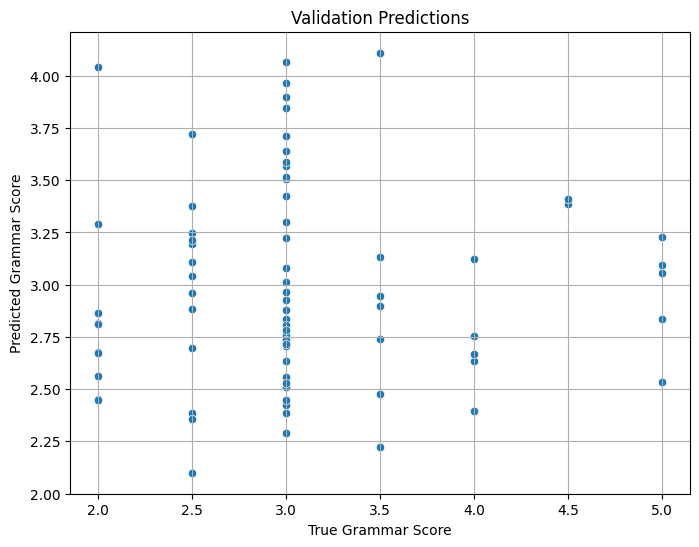

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_val, y=grammar_model.predict(X_val))
plt.xlabel("True Grammar Score")
plt.ylabel("Predicted Grammar Score")
plt.title("Validation Predictions")
plt.grid(True)
plt.show()


**📌 Feature Importance Analysis**

I also looked at the feature importance scores from the trained Random Forest model. This shows which features had the most influence on the predictions. It’s useful for understanding which aspects of grammar (like sentence count or verb usage) the model relies on most when scoring.

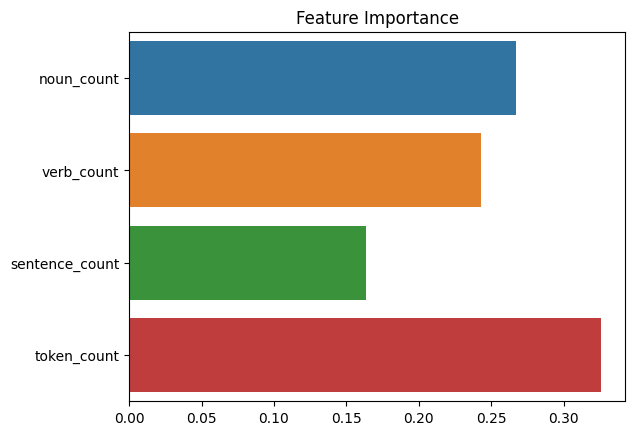

In [37]:
importances = grammar_model.feature_importances_
feature_names = X_train.columns
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importance")
plt.show()


In [39]:
submission_df = test_df[['filename', 'label']]
submission_df.to_csv('/kaggle/working/submission.csv', index=False)
